 ### By : Ahmed Mustafa & Mohamed Motaz
 ---

### import libraries

In [48]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import SubsetRandomSampler
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score
import torchvision.datasets as datasets
from sklearn.metrics import accuracy_score, precision_score, recall_score

import torch.nn.functional as F
from torchvision.datasets import FashionMNIST

### Defining Functions

In [124]:
def plot_metrics(loss_keeper, accuracy_keeper):
    epochs = range(1, len(loss_keeper['train']) + 1)

    # Plotting loss
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, loss_keeper['train'], 'b', label='Training loss')
    plt.plot(epochs, loss_keeper['valid'], 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Plotting accuracy
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, accuracy_keeper['train'], 'b', label='Training accuracy')
    plt.plot(epochs, accuracy_keeper['valid'], 'r', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()



def test_accuracy(model, test_loader):
    model.eval()  # Set the model to evaluation mode
    model.cuda()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to('cuda')  # Move images to GPU if available
            labels = labels.to('cuda')  # Move labels to GPU if available
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy




def weight_init_normal(m):
    classname=m.__class__.__name__
    if classname.find('Linear')!=-1:
        n = m.in_features
        y = (1.0/np.sqrt(n))
        m.weight.data.normal_(0, y)
        m.bias.data.fill_(0)




def trainNet(model, lr ,optimizer ="RMSprop" , Aug = False):
  if optimizer == "RMSprop":
    z = type(model).__name__ + optimizer
    optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
  elif optimizer == "Adam":
    z = type(model).__name__ + optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  elif optimizer == "SGD":
    z = type(model).__name__ + optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
  else:
    z = type(model).__name__ + optimizer
    optimizer = torch.optim.Adadelta(model.parameters(), lr=lr)


  # Number of epochs to train for
  loss_keeper = {'train': [], 'valid': []}
  accuracy_keeper = {'train': [], 'valid': []}
  precision_keeper = {'train': [], 'valid': []}
  recall_keeper = {'train': [], 'valid': []}
  epochs = 4

  # Minimum validation loss ----- set initial minimum to infinity
  valid_loss_min = np.Inf

  for epoch in range(epochs):
      train_loss = 0.0
      valid_loss = 0.0
      train_predictions = []
      train_true_labels = []
      valid_predictions = []
      valid_true_labels = []

      """
      TRAINING PHASE
      """
      model.train()  # TURN ON DROPOUT for training
      if Aug:
        for images, labels in train_loader_augmented:
            if use_cuda and torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            # Save predictions and true labels for metrics calculation
            train_predictions.extend(torch.argmax(output, dim=1).cpu().numpy())
            train_true_labels.extend(labels.cpu().numpy())
      else:
        for images, labels in train_loader:
            if use_cuda and torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            # Save predictions and true labels for metrics calculation
            train_predictions.extend(torch.argmax(output, dim=1).cpu().numpy())
            train_true_labels.extend(labels.cpu().numpy())

      """
      VALIDATION PHASE
      """
      model.eval()  # TURN OFF DROPOUT for validation
      for images, labels in valid_loader:
          if use_cuda and torch.cuda.is_available():
              images, labels = images.cuda(), labels.cuda()
          output = model(images)
          loss = criterion(output, labels)
          valid_loss += loss.item()

          # Save predictions and true labels for metrics calculation
          valid_predictions.extend(torch.argmax(output, dim=1).cpu().numpy())
          valid_true_labels.extend(labels.cpu().numpy())

      # Calculate loss over entire batch size for every epoch
      train_loss = train_loss / len(train_loader)
      valid_loss = valid_loss / len(valid_loader)

      # Calculate evaluation metrics
      train_accuracy = accuracy_score(train_true_labels, train_predictions)
      valid_accuracy = accuracy_score(valid_true_labels, valid_predictions)
      train_precision = precision_score(train_true_labels, train_predictions, average='macro')
      valid_precision = precision_score(valid_true_labels, valid_predictions, average='macro')
      train_recall = recall_score(train_true_labels, train_predictions, average='macro')
      valid_recall = recall_score(valid_true_labels, valid_predictions, average='macro')

      # Saving loss values and evaluation metrics
      loss_keeper['train'].append(train_loss)
      loss_keeper['valid'].append(valid_loss)
      accuracy_keeper['train'].append(train_accuracy)
      accuracy_keeper['valid'].append(valid_accuracy)
      precision_keeper['train'].append(train_precision)
      precision_keeper['valid'].append(valid_precision)
      recall_keeper['train'].append(train_recall)
      recall_keeper['valid'].append(valid_recall)

      print(f"\nEpoch : {epoch + 1}\tTraining Loss : {train_loss}\tValidation Loss : {valid_loss}")
      print(f"Training Accuracy : {train_accuracy}\tValidation Accuracy : {valid_accuracy}")
      # print(f"Training Precision : {train_precision}\tValidation Precision : {valid_precision}")
      # print(f"Training Recall : {train_recall}\tValidation Recall : {valid_recall}")

      if valid_loss <= valid_loss_min:
          print(f"Validation loss decreased from : {valid_loss_min} ----> {valid_loss} ----> Saving Model.......")

          torch.save(model.state_dict(), z + '_model.pth')
          valid_loss_min = valid_loss

  return loss_keeper, accuracy_keeper, precision_keeper, recall_keeper


In [50]:
transform=transforms.Compose([transforms.ToTensor()])

### Loading Data

In [51]:
train_data=datasets.FashionMNIST('data',train=True,download=True,transform=transform)
test_data=datasets.FashionMNIST('data',train=False,download=True,transform=transform)


train_transform_aug = transforms.Compose([
                                transforms.RandomHorizontalFlip(),
                                transforms.RandomRotation(10),
                                transforms.ToTensor(),
                            ])


train_set_augmented = torchvision.datasets.FashionMNIST(root='./data', train=True,download=True,transform=train_transform_aug)

In [52]:

valid_size=0.2
train_length=len(train_data)

indices=[i for i in range(train_length)]
np.random.shuffle(indices)

split=int(np.floor(valid_size*train_length))
train_idx=indices[split:]
valid_idx=indices[:split]


train_sampler=SubsetRandomSampler(train_idx)
valid_sampler=SubsetRandomSampler(valid_idx)

num_workers=0
batch_size=20
train_loader=torch.utils.data.DataLoader(train_data,batch_size=batch_size,sampler=train_sampler,num_workers=num_workers)
valid_loader=torch.utils.data.DataLoader(train_data,batch_size=batch_size,sampler=train_sampler,num_workers=num_workers)
test_loader=torch.utils.data.DataLoader(test_data,batch_size=batch_size,num_workers=num_workers,shuffle = True)
train_loader_augmented = torch.utils.data.DataLoader(train_set_augmented,batch_size=batch_size,sampler=train_sampler,num_workers=num_workers)


# This is for debugging
print(f"Training data size : {train_idx.__len__()}, Validation data size : {valid_idx.__len__()}, Test data size : {test_loader.dataset.__len__()}")


Training data size : 48000, Validation data size : 12000, Test data size : 10000


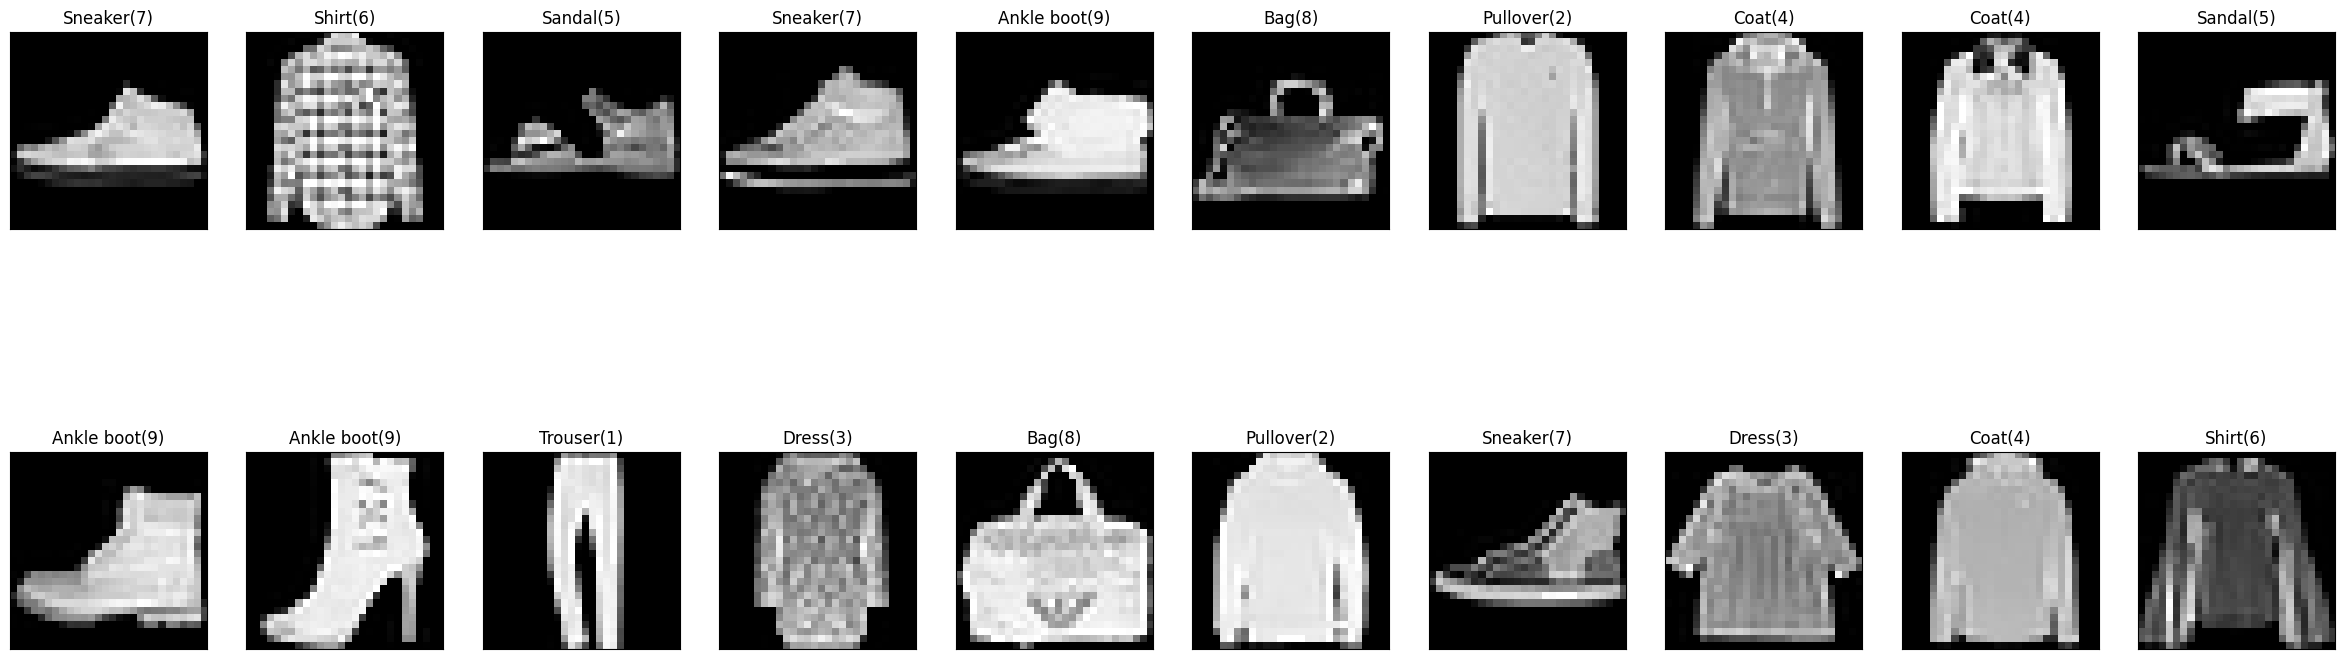

In [53]:

for images, labels in train_loader:
    pass

fashion_class={
    0:"T-shirt/top",
    1:"Trouser",
    2:"Pullover",
    3:"Dress",
    4:"Coat",
    5:"Sandal",
    6:"Shirt",
    7:"Sneaker",
    8:"Bag",
    9:"Ankle boot"
}

fig=plt.figure(figsize=(30,10))
for i in range(len(labels)):
    ax=fig.add_subplot(2,10,i+1,xticks=[],yticks=[])
    plt.imshow(np.squeeze(images[i]), cmap='gray')
    ax.set_title(f"{fashion_class[labels[i].item()]}({labels[i].item()})")

### Defaine Models Classes Architecture.



Fully connected neural network.

simple CNN.

CNN.

CNN + sigmoid.

CNN + Average pooling.

LeNet5.

LeNet5 + maxpooling + sigmoid.

CNN + Augmanted data.

LeNet5 + Augmanted data.

In [129]:
class FNet(nn.Module):
    def __init__(self):
        super(FNet,self).__init__()
        self.fc1=nn.Linear(784,512)
        self.fc2=nn.Linear(512,256)
        self.out=nn.Linear(256,10)

    def forward(self,x):
        x = x.view(-1, 28 * 28)
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = self.out(x)
        return x



class CNN_1(nn.Module):
    def __init__(self):
        super(CNN_1, self).__init__()
        # a conv layer that applay 16 filters.
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(16 * 14 * 14, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 10)

    def forward(self, x):
        # Convolutional layer followed by max pooling
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # Reshape the tensor for fully connected layers
        x = x.view(-1, 16 * 14 * 14)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x





class convNet_sig(nn.Module):
    def __init__(self):
        super(convNet_sig,self).__init__()
        self.conv1=nn.Conv2d(in_channels=1,out_channels=16,kernel_size=3,padding=1,stride=1)
        self.conv1_bn = nn.BatchNorm2d(16)  # Batch normalization after first convolution
        self.conv2=nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,padding=1,stride=1)
        self.conv2_bn = nn.BatchNorm2d(32)  # Batch normalization after second convolution
        self.pool=nn.MaxPool2d(kernel_size=2,stride=2)

        self.fc1=nn.Linear(7*7*32,512)
        self.fc2=nn.Linear(512,256)
        self.out=nn.Linear(256,10)

    def forward(self,x):
        x = self.pool(F.sigmoid(self.conv1_bn(self.conv1(x))))  # Apply batch normalization after first convolution
        x = self.pool(F.sigmoid(self.conv2_bn(self.conv2(x))))  # Apply batch normalization after second convolution
        x = x.view(-1, 7 * 7 * 32)
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = self.out(x)
        return x



class convNet_Avg(nn.Module):
    def __init__(self):
        super(convNet_Avg,self).__init__()
        self.conv1=nn.Conv2d(in_channels=1,out_channels=16,kernel_size=3,padding=1,stride=1)
        self.conv1_bn = nn.BatchNorm2d(16)  # Batch normalization after first convolution
        self.conv2=nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,padding=1,stride=1)
        self.conv2_bn = nn.BatchNorm2d(32)  # Batch normalization after second convolution
        self.pool=nn.AvgPool2d(kernel_size=2,stride=2)  # Average pooling instead of max pooling

        self.fc1=nn.Linear(7*7*32,512)
        self.fc2=nn.Linear(512,256)
        self.out=nn.Linear(256,10)

    def forward(self,x):
        x = self.pool(F.tanh(self.conv1_bn(self.conv1(x))))  # Apply batch normalization after first convolution
        x = self.pool(F.tanh(self.conv2_bn(self.conv2(x))))  # Apply batch normalization after second convolution
        x = x.view(-1, 7 * 7 * 32)
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = self.out(x)
        return x









class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature = nn.Sequential(
            #1
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2),   # 28*28->32*32-->28*28
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),  # 14*14

            #2
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),  # 10*10
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),  # 5*5

        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16*5*5, out_features=120),
            nn.Tanh(),
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=10),
        )

    def forward(self, x):
        return self.classifier(self.feature(x))





class LeNet5_Max_sig(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature = nn.Sequential(
            #1
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2),   # 28*28->32*32-->28*28
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 14*14

            #2
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),  # 10*10
            nn.Sigmoid(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # 5*5

        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16*5*5, out_features=120),
            nn.Sigmoid(),
            nn.Linear(in_features=120, out_features=84),
            nn.Sigmoid(),
            nn.Linear(in_features=84, out_features=10),
        )

    def forward(self, x):
        return self.classifier(self.feature(x))



class convNet_Drop(nn.Module):
    def __init__(self):
        super(convNet_Drop, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, padding=1, stride=1)
        self.conv1_bn = nn.BatchNorm2d(16)  # Batch normalization after first convolution
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1)
        self.conv2_bn = nn.BatchNorm2d(32)  # Batch normalization after second convolution
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)  # Average pooling instead of max pooling
        self.dropout = nn.Dropout(p=0.05)  # Dropout layer with probability 0.05

        self.fc1 = nn.Linear(7 * 7 * 32, 512)
        self.fc2 = nn.Linear(512, 256)
        self.out = nn.Linear(256, 10)

    def forward(self, x):
        x = self.pool(F.tanh(self.conv1_bn(self.conv1(x))))  # Apply batch normalization after first convolution
        x = self.dropout(x)  # Apply dropout
        x = self.pool(F.tanh(self.conv2_bn(self.conv2(x))))  # Apply batch normalization after second convolution
        x = self.dropout(x)  # Apply dropout
        x = x.view(-1, 7 * 7 * 32)
        x = F.tanh(self.fc1(x))
        x = self.dropout(x)  # Apply dropout
        x = F.tanh(self.fc2(x))
        x = self.dropout(x)  # Apply dropout
        x = self.out(x)
        return x




### Initializing models

In [130]:
model_1_FCNN = FNet()
model_2_simpleCNN = CNN_1()
model_3_CNN = convNet_sig()
model_4_CNN_AvgPool = convNet_Avg()
model_5_Net5 = LeNet5()
model_6_Net5_sig_max = LeNet5_Max_sig()
model_7_convNet_DropModel = convNet_Drop()


In [131]:
model_1_FCNN.apply(weight_init_normal),model_2_simpleCNN.apply(weight_init_normal),model_3_CNN.apply(weight_init_normal),model_4_CNN_AvgPool.apply(weight_init_normal),model_5_Net5.apply(weight_init_normal),model_6_Net5_sig_max.apply(weight_init_normal),model_7_convNet_DropModel.apply(weight_init_normal)

use_cuda=True
if use_cuda and torch.cuda.is_available():
  model_1_FCNN.cuda()
  model_2_simpleCNN.cuda()
  model_3_CNN.cuda()
  model_4_CNN_AvgPool.cuda()
  model_5_Net5.cuda()
  model_6_Net5_sig_max.cuda()
  model_7_convNet_DropModel.cuda()


print(model_1_FCNN,'\n\n\n\n',model_2_simpleCNN,'\n\n\n\n',model_3_CNN,'\n\n\n\n',model_4_CNN_AvgPool,'\n\n\n\n')
print(model_5_Net5,'\n\n\n\n',model_6_Net5_sig_max,'\n\n\n\n',model_7_convNet_DropModel)


FNet(
  (fc1): Linear(in_features=784, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=10, bias=True)
) 



 CNN_1(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=3136, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
) 



 convNet_sig(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv1_bn): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2_bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (f

In [57]:
criterion=nn.CrossEntropyLoss()


### 1st model FCNN

#### Adam

In [58]:
model_One = trainNet(model_1_FCNN,0.001,"Adam")


Epoch : 1	Training Loss : 0.49762484602164475	Validation Loss : 0.4834876592302074
Training Accuracy : 0.8165833333333333	Validation Accuracy : 0.8139166666666666
Validation loss decreased from : inf ----> 0.4834876592302074 ----> Saving Model.......

Epoch : 2	Training Loss : 0.3957526130632808	Validation Loss : 0.33631072915314386
Training Accuracy : 0.8545208333333333	Validation Accuracy : 0.8735416666666667
Validation loss decreased from : 0.4834876592302074 ----> 0.33631072915314386 ----> Saving Model.......

Epoch : 3	Training Loss : 0.3660101405174161	Validation Loss : 0.3695799909206107
Training Accuracy : 0.8637916666666666	Validation Accuracy : 0.8616666666666667

Epoch : 4	Training Loss : 0.35073542293316373	Validation Loss : 0.33303196388296785
Training Accuracy : 0.8689791666666666	Validation Accuracy : 0.8753958333333334
Validation loss decreased from : 0.33631072915314386 ----> 0.33303196388296785 ----> Saving Model.......


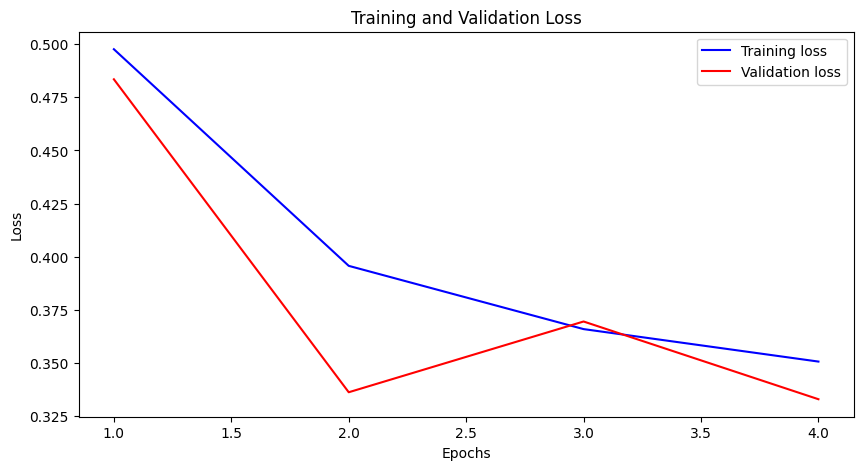

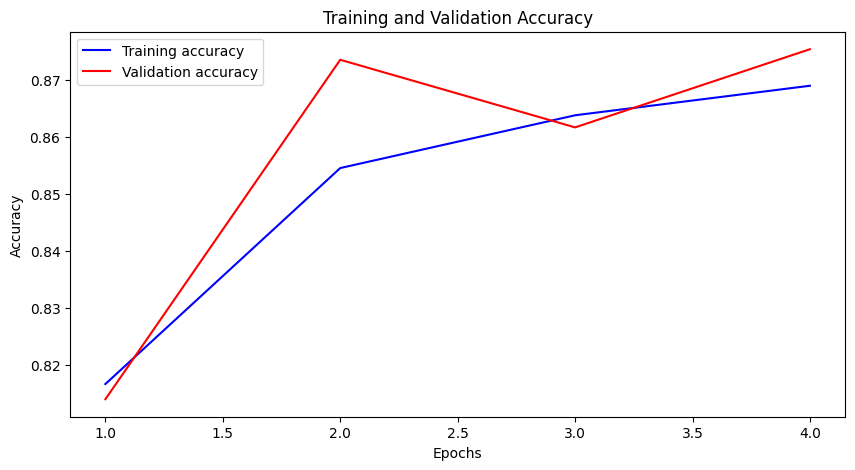

In [59]:
loss_keeper, accuracy_keeper, precision_keeper, recall_keeper = model_One
plot_metrics(loss_keeper, accuracy_keeper)

In [60]:
test_accuracy(model_1_FCNN, test_loader)

85.4

#### SGD

In [61]:
model_One = trainNet(model_1_FCNN,0.001,"SGD")


Epoch : 1	Training Loss : 0.2988487174618058	Validation Loss : 0.29059852206381037
Training Accuracy : 0.8906041666666666	Validation Accuracy : 0.893125
Validation loss decreased from : inf ----> 0.29059852206381037 ----> Saving Model.......

Epoch : 2	Training Loss : 0.287977395906734	Validation Loss : 0.2850196960715887
Training Accuracy : 0.895	Validation Accuracy : 0.8959791666666667
Validation loss decreased from : 0.29059852206381037 ----> 0.2850196960715887 ----> Saving Model.......

Epoch : 3	Training Loss : 0.28384580549201927	Validation Loss : 0.2817294355334404
Training Accuracy : 0.8967916666666667	Validation Accuracy : 0.8969375
Validation loss decreased from : 0.2850196960715887 ----> 0.2817294355334404 ----> Saving Model.......

Epoch : 4	Training Loss : 0.281069399289942	Validation Loss : 0.2791012234504645
Training Accuracy : 0.8975416666666667	Validation Accuracy : 0.8982083333333334
Validation loss decreased from : 0.2817294355334404 ----> 0.2791012234504645 ----> S

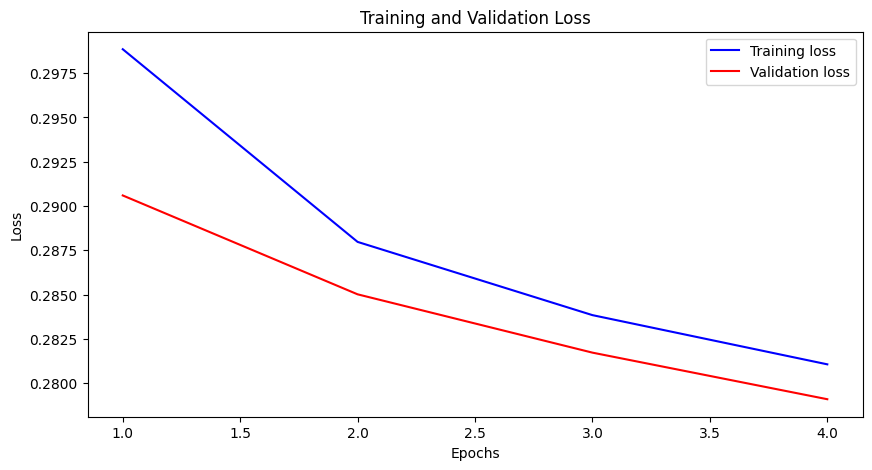

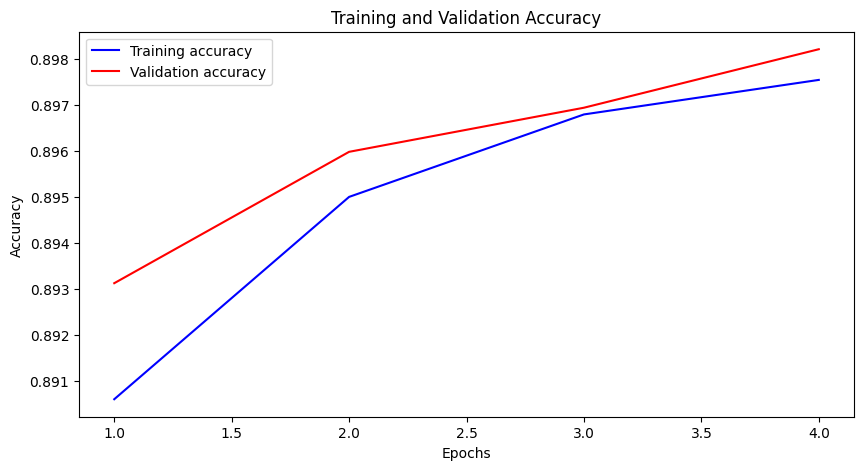

In [62]:
loss_keeper, accuracy_keeper, precision_keeper, recall_keeper = model_One
plot_metrics(loss_keeper, accuracy_keeper)

In [63]:
test_accuracy(model_1_FCNN, test_loader)

87.65

#### RMSprop

In [64]:
model_One = trainNet(model_1_FCNN,0.001,"RMSprop")


Epoch : 1	Training Loss : 0.3440675121254753	Validation Loss : 0.3493691787170246
Training Accuracy : 0.8732291666666666	Validation Accuracy : 0.8664583333333333
Validation loss decreased from : inf ----> 0.3493691787170246 ----> Saving Model.......

Epoch : 2	Training Loss : 0.3233852549549192	Validation Loss : 0.324384937894841
Training Accuracy : 0.88	Validation Accuracy : 0.8805833333333334
Validation loss decreased from : 0.3493691787170246 ----> 0.324384937894841 ----> Saving Model.......

Epoch : 3	Training Loss : 0.3154040214753089	Validation Loss : 0.29871848154463804
Training Accuracy : 0.8826875	Validation Accuracy : 0.8856041666666666
Validation loss decreased from : 0.324384937894841 ----> 0.29871848154463804 ----> Saving Model.......

Epoch : 4	Training Loss : 0.30708944907179103	Validation Loss : 0.27953828386729584
Training Accuracy : 0.886125	Validation Accuracy : 0.8950833333333333
Validation loss decreased from : 0.29871848154463804 ----> 0.27953828386729584 ----> S

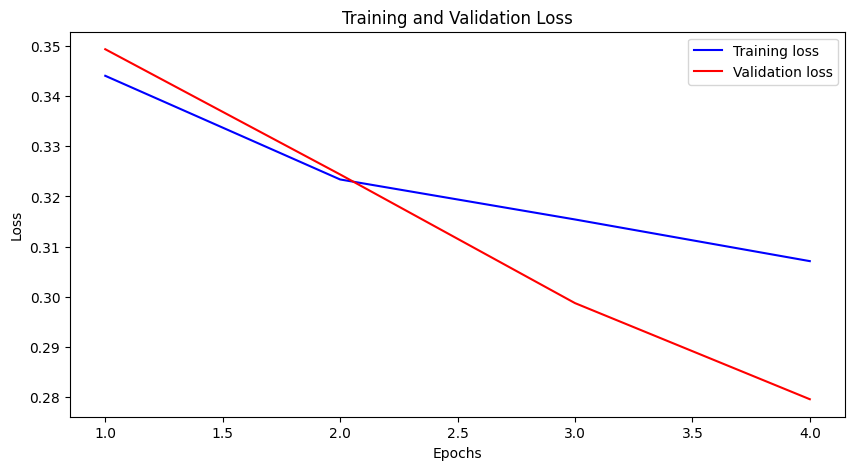

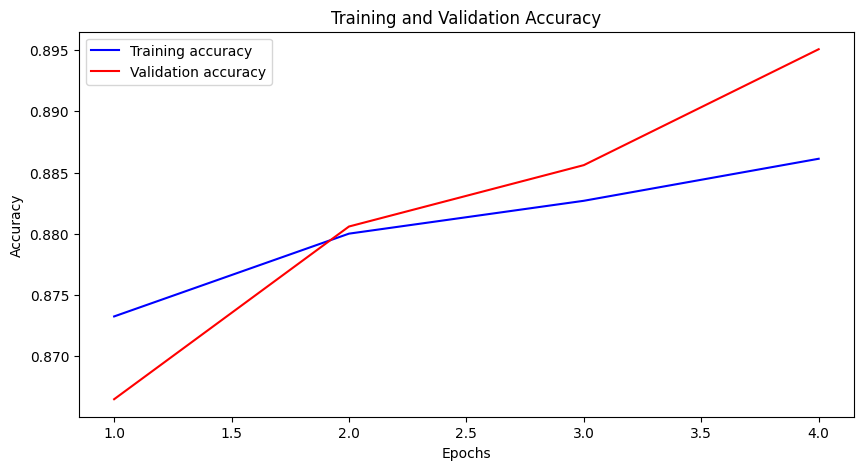

In [65]:
loss_keeper, accuracy_keeper, precision_keeper, recall_keeper = model_One
plot_metrics(loss_keeper, accuracy_keeper)

In [66]:
test_accuracy(model_1_FCNN, test_loader)

86.51

### 2nd model Simple CNN

#### Adam

In [67]:
model_2 = trainNet(model_2_simpleCNN,0.001,"Adam")


Epoch : 1	Training Loss : 0.45599878273904326	Validation Loss : 0.30183742377130934
Training Accuracy : 0.8364583333333333	Validation Accuracy : 0.8898333333333334
Validation loss decreased from : inf ----> 0.30183742377130934 ----> Saving Model.......

Epoch : 2	Training Loss : 0.3018353063523925	Validation Loss : 0.25189399681364494
Training Accuracy : 0.8887291666666667	Validation Accuracy : 0.9053333333333333
Validation loss decreased from : 0.30183742377130934 ----> 0.25189399681364494 ----> Saving Model.......

Epoch : 3	Training Loss : 0.2526090434018988	Validation Loss : 0.2138128381536808
Training Accuracy : 0.9055833333333333	Validation Accuracy : 0.9208125
Validation loss decreased from : 0.25189399681364494 ----> 0.2138128381536808 ----> Saving Model.......

Epoch : 4	Training Loss : 0.22238857553786753	Validation Loss : 0.1942689269790814
Training Accuracy : 0.9171666666666667	Validation Accuracy : 0.9269791666666667
Validation loss decreased from : 0.2138128381536808 ---

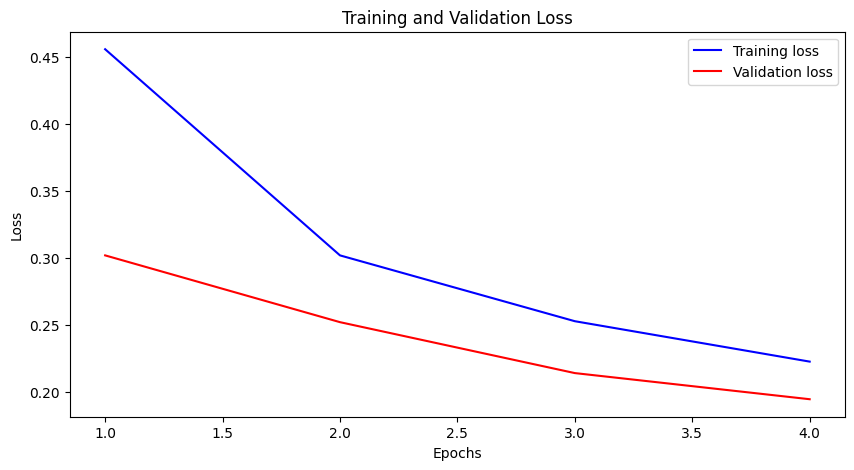

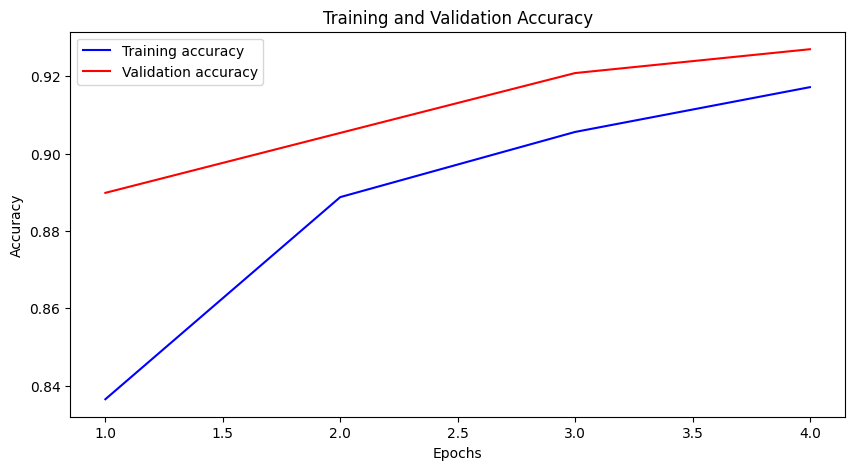

In [68]:
loss_keeper, accuracy_keeper, precision_keeper, recall_keeper = model_2
plot_metrics(loss_keeper, accuracy_keeper)

In [69]:
test_accuracy(model_2_simpleCNN, test_loader)

89.85

#### SGD

In [70]:
model_2 = trainNet(model_2_simpleCNN,0.001,"SGD")


Epoch : 1	Training Loss : 0.17293780494044766	Validation Loss : 0.16683379032445372
Training Accuracy : 0.9368125	Validation Accuracy : 0.9387291666666666
Validation loss decreased from : inf ----> 0.16683379032445372 ----> Saving Model.......

Epoch : 2	Training Loss : 0.16579041792448454	Validation Loss : 0.16370585750274283
Training Accuracy : 0.9387291666666666	Validation Accuracy : 0.9400416666666667
Validation loss decreased from : 0.16683379032445372 ----> 0.16370585750274283 ----> Saving Model.......

Epoch : 3	Training Loss : 0.1632875231616587	Validation Loss : 0.16200413446883127
Training Accuracy : 0.9397291666666666	Validation Accuracy : 0.94075
Validation loss decreased from : 0.16370585750274283 ----> 0.16200413446883127 ----> Saving Model.......

Epoch : 4	Training Loss : 0.1613966503830549	Validation Loss : 0.1601273781133932
Training Accuracy : 0.940625	Validation Accuracy : 0.941375
Validation loss decreased from : 0.16200413446883127 ----> 0.1601273781133932 ----> 

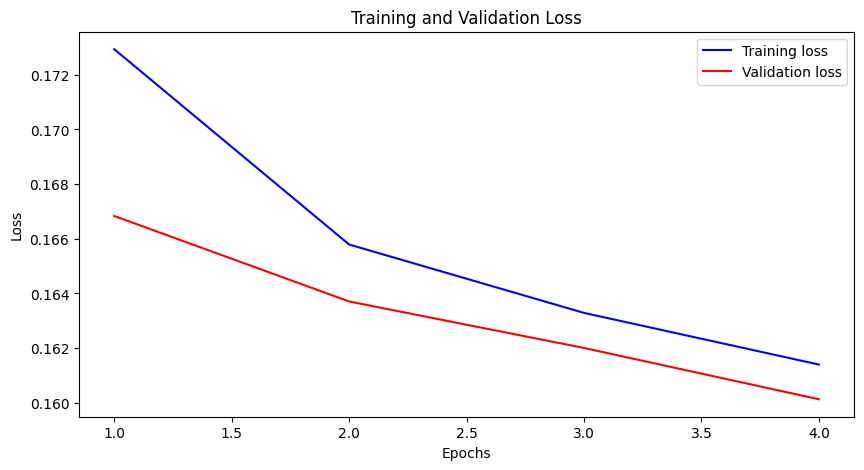

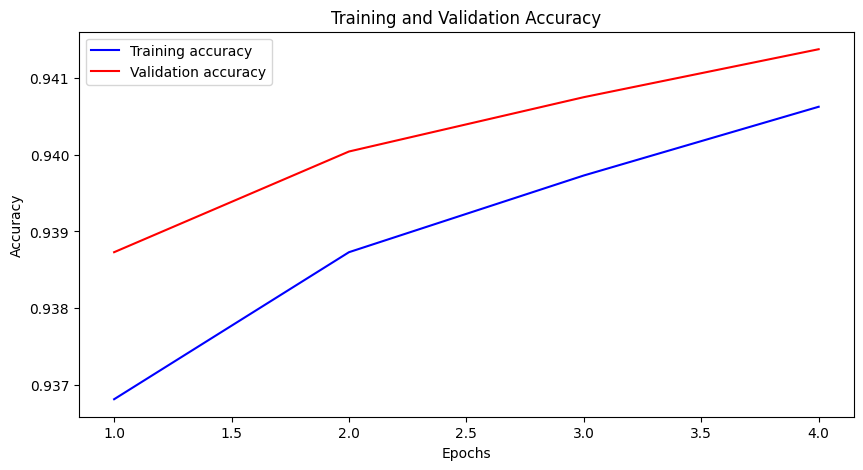

In [71]:
loss_keeper, accuracy_keeper, precision_keeper, recall_keeper = model_2
plot_metrics(loss_keeper, accuracy_keeper)

In [72]:
test_accuracy(model_2_simpleCNN, test_loader)

90.89

#### RMSprop

In [73]:
model_2 = trainNet(model_2_simpleCNN,0.001,"RMSprop")


Epoch : 1	Training Loss : 0.2015227521308892	Validation Loss : 0.18096334083820692
Training Accuracy : 0.9257083333333334	Validation Accuracy : 0.9318541666666667
Validation loss decreased from : inf ----> 0.18096334083820692 ----> Saving Model.......

Epoch : 2	Training Loss : 0.17664271809437196	Validation Loss : 0.16619599493681259
Training Accuracy : 0.9346458333333333	Validation Accuracy : 0.93875
Validation loss decreased from : 0.18096334083820692 ----> 0.16619599493681259 ----> Saving Model.......

Epoch : 3	Training Loss : 0.15906559305799117	Validation Loss : 0.12592668178258465
Training Accuracy : 0.9417083333333334	Validation Accuracy : 0.9543958333333333
Validation loss decreased from : 0.16619599493681259 ----> 0.12592668178258465 ----> Saving Model.......

Epoch : 4	Training Loss : 0.14314015348563164	Validation Loss : 0.11752345410893517
Training Accuracy : 0.9466666666666667	Validation Accuracy : 0.955625
Validation loss decreased from : 0.12592668178258465 ----> 0.11

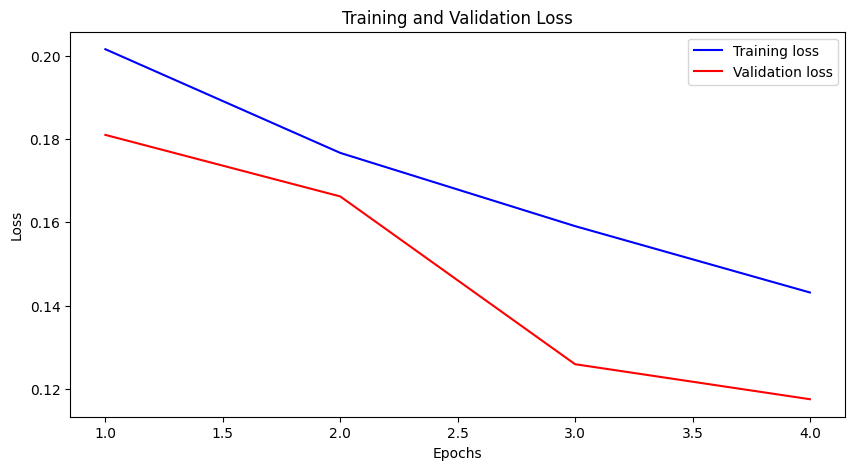

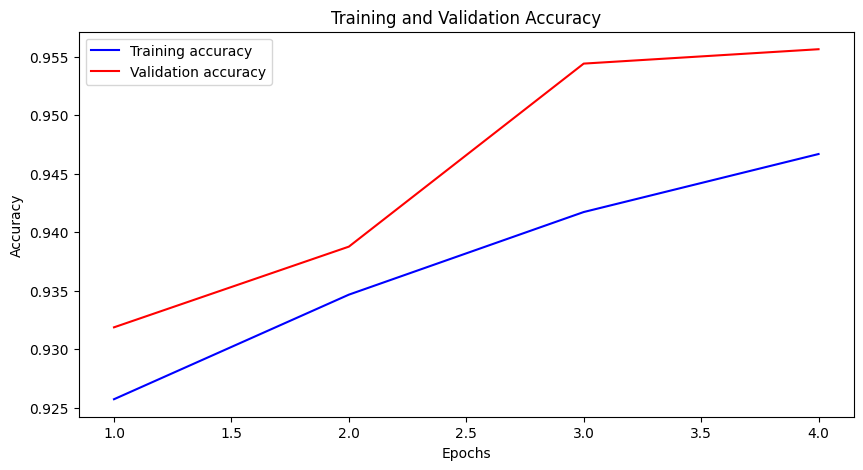

In [74]:
loss_keeper, accuracy_keeper, precision_keeper, recall_keeper = model_2
plot_metrics(loss_keeper, accuracy_keeper)

In [75]:
test_accuracy(model_2_simpleCNN, test_loader)

90.6

### 3rd model CNN

#### Adam

In [76]:
model_3 = trainNet(model_3_CNN,0.001,"Adam")


Epoch : 1	Training Loss : 0.5875424346498525	Validation Loss : 0.4611234446017382
Training Accuracy : 0.7810625	Validation Accuracy : 0.8277083333333334
Validation loss decreased from : inf ----> 0.4611234446017382 ----> Saving Model.......

Epoch : 2	Training Loss : 0.3700889639928937	Validation Loss : 0.33550396567753826
Training Accuracy : 0.8663958333333334	Validation Accuracy : 0.8768541666666667
Validation loss decreased from : 0.4611234446017382 ----> 0.33550396567753826 ----> Saving Model.......

Epoch : 3	Training Loss : 0.32239361223454277	Validation Loss : 0.2765789847238921
Training Accuracy : 0.8825208333333333	Validation Accuracy : 0.9002708333333334
Validation loss decreased from : 0.33550396567753826 ----> 0.2765789847238921 ----> Saving Model.......

Epoch : 4	Training Loss : 0.29796015317629404	Validation Loss : 0.27762160457437857
Training Accuracy : 0.8914375	Validation Accuracy : 0.8982708333333334


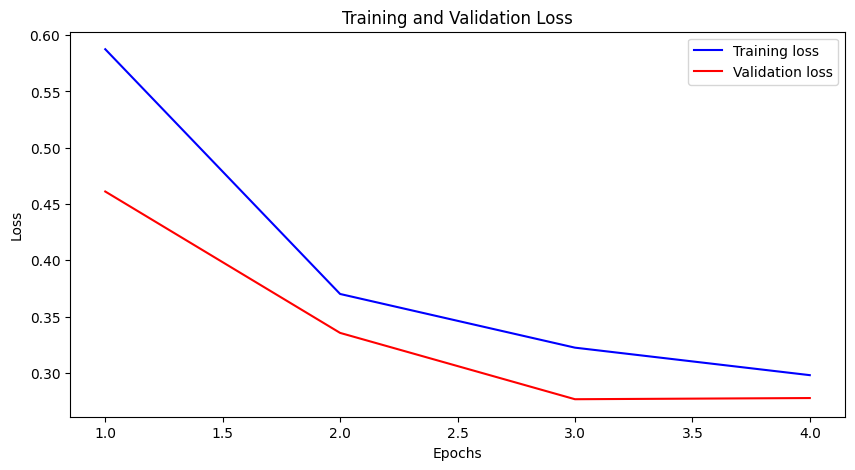

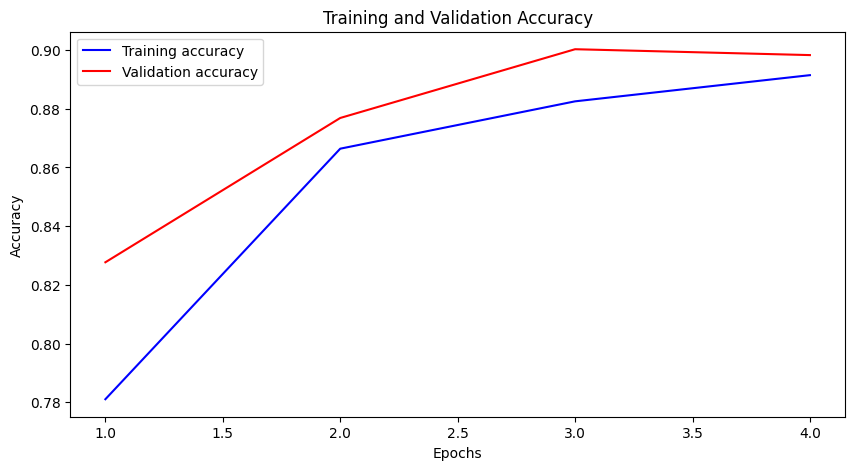

In [77]:
loss_keeper, accuracy_keeper, precision_keeper, recall_keeper = model_3
plot_metrics(loss_keeper, accuracy_keeper)

In [78]:
test_accuracy(model_3_CNN, test_loader)

88.73

#### SGD

In [79]:
model_3 = trainNet(model_3_CNN,0.001,"SGD")


Epoch : 1	Training Loss : 0.24596699273019718	Validation Loss : 0.24022922612959519
Training Accuracy : 0.9108541666666666	Validation Accuracy : 0.9127708333333333
Validation loss decreased from : inf ----> 0.24022922612959519 ----> Saving Model.......

Epoch : 2	Training Loss : 0.24003755468254287	Validation Loss : 0.23673918459913693
Training Accuracy : 0.9136666666666666	Validation Accuracy : 0.9143333333333333
Validation loss decreased from : 0.24022922612959519 ----> 0.23673918459913693 ----> Saving Model.......

Epoch : 3	Training Loss : 0.23752549123795083	Validation Loss : 0.2343841613763167
Training Accuracy : 0.9142083333333333	Validation Accuracy : 0.9156875
Validation loss decreased from : 0.23673918459913693 ----> 0.2343841613763167 ----> Saving Model.......

Epoch : 4	Training Loss : 0.2357639628543984	Validation Loss : 0.23472889889012247
Training Accuracy : 0.9144375	Validation Accuracy : 0.9148125


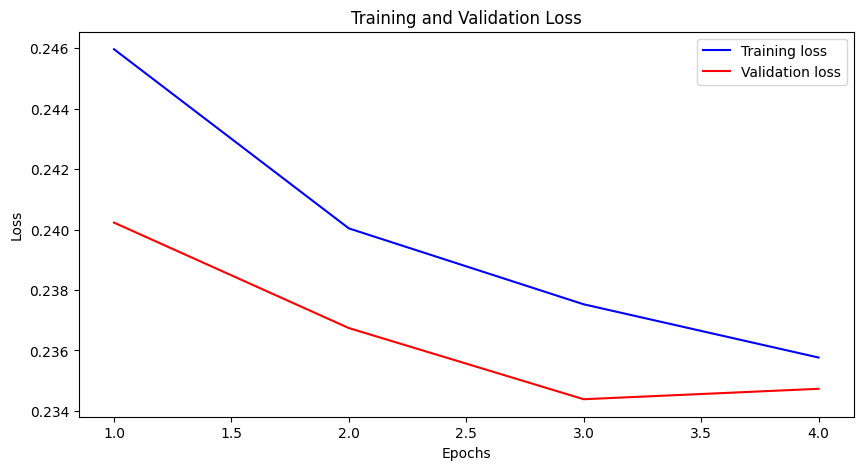

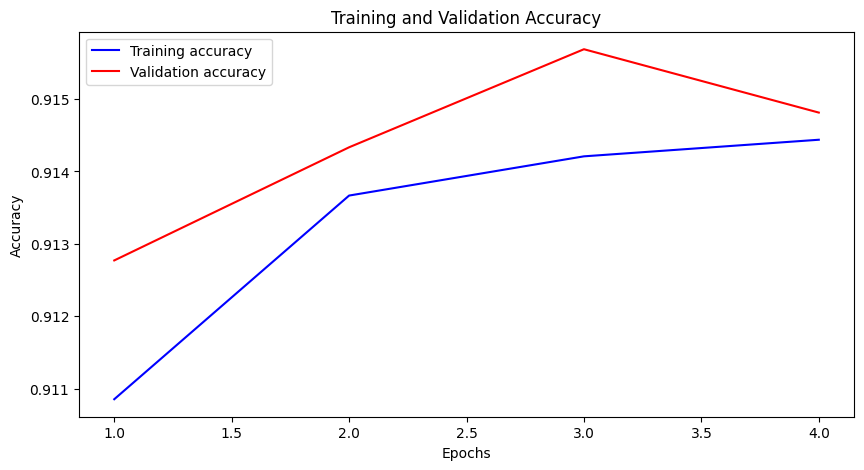

In [80]:
loss_keeper, accuracy_keeper, precision_keeper, recall_keeper = model_3
plot_metrics(loss_keeper, accuracy_keeper)

In [81]:
test_accuracy(model_3_CNN, test_loader)

89.85

#### RMSprop

In [82]:
model_3 = trainNet(model_3_CNN,0.001,"RMSprop")


Epoch : 1	Training Loss : 0.2841033973036489	Validation Loss : 0.27955420486202154
Training Accuracy : 0.8961875	Validation Accuracy : 0.89625
Validation loss decreased from : inf ----> 0.27955420486202154 ----> Saving Model.......

Epoch : 2	Training Loss : 0.26299354575923645	Validation Loss : 0.3155074124340899
Training Accuracy : 0.9036666666666666	Validation Accuracy : 0.8821666666666667

Epoch : 3	Training Loss : 0.2478288481698837	Validation Loss : 0.23675490953804304
Training Accuracy : 0.9098541666666666	Validation Accuracy : 0.9124375
Validation loss decreased from : 0.27955420486202154 ----> 0.23675490953804304 ----> Saving Model.......

Epoch : 4	Training Loss : 0.23402575281885218	Validation Loss : 0.20360620138856272
Training Accuracy : 0.916	Validation Accuracy : 0.9248541666666666
Validation loss decreased from : 0.23675490953804304 ----> 0.20360620138856272 ----> Saving Model.......


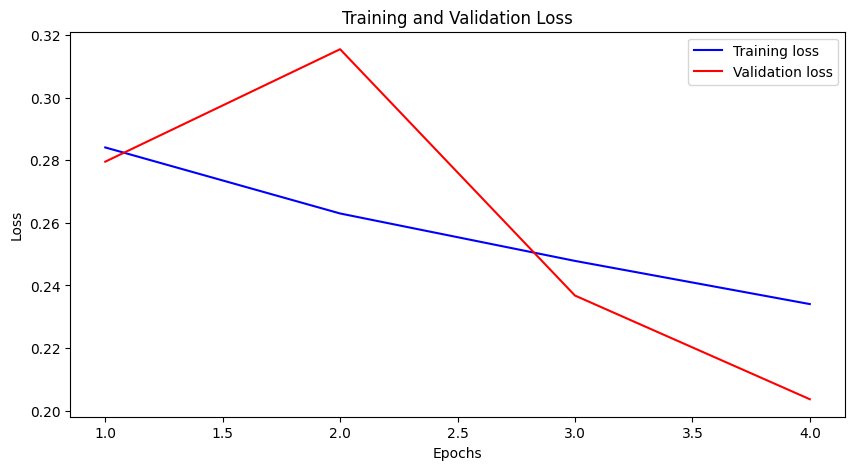

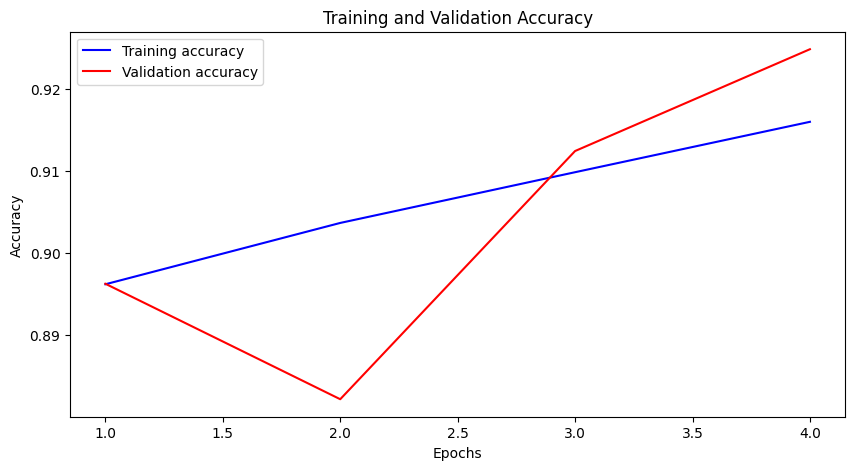

In [83]:
loss_keeper, accuracy_keeper, precision_keeper, recall_keeper = model_3
plot_metrics(loss_keeper, accuracy_keeper)

In [84]:
test_accuracy(model_3_CNN, test_loader)

90.82

### 4th model CNN + Avgrage Pooling

#### Adam

In [85]:
model_4 = trainNet(model_4_CNN_AvgPool,0.001,"Adam")


Epoch : 1	Training Loss : 0.44366486856093007	Validation Loss : 0.32357498885598035
Training Accuracy : 0.8382291666666667	Validation Accuracy : 0.8822916666666667
Validation loss decreased from : inf ----> 0.32357498885598035 ----> Saving Model.......

Epoch : 2	Training Loss : 0.3263123257923871	Validation Loss : 0.2820101522048935
Training Accuracy : 0.8811458333333333	Validation Accuracy : 0.8969583333333333
Validation loss decreased from : 0.32357498885598035 ----> 0.2820101522048935 ----> Saving Model.......

Epoch : 3	Training Loss : 0.2879588658568294	Validation Loss : 0.27915946224859606
Training Accuracy : 0.894625	Validation Accuracy : 0.893875
Validation loss decreased from : 0.2820101522048935 ----> 0.27915946224859606 ----> Saving Model.......

Epoch : 4	Training Loss : 0.2606555127236061	Validation Loss : 0.2466062658986387
Training Accuracy : 0.904625	Validation Accuracy : 0.9078958333333333
Validation loss decreased from : 0.27915946224859606 ----> 0.2466062658986387 

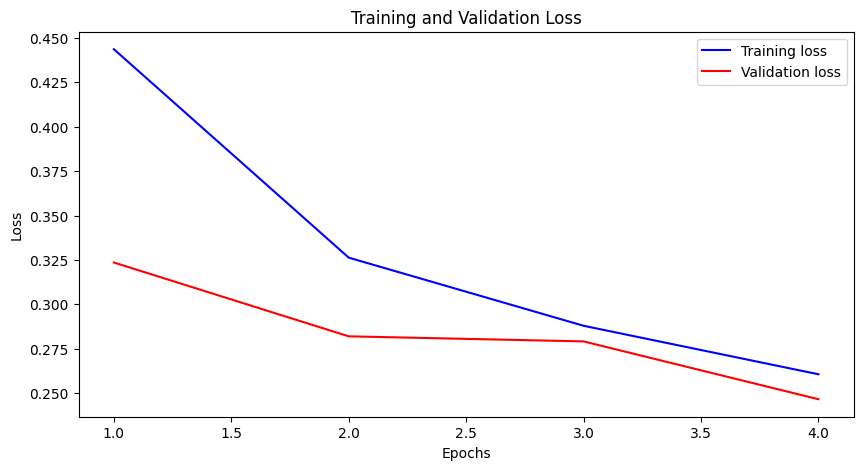

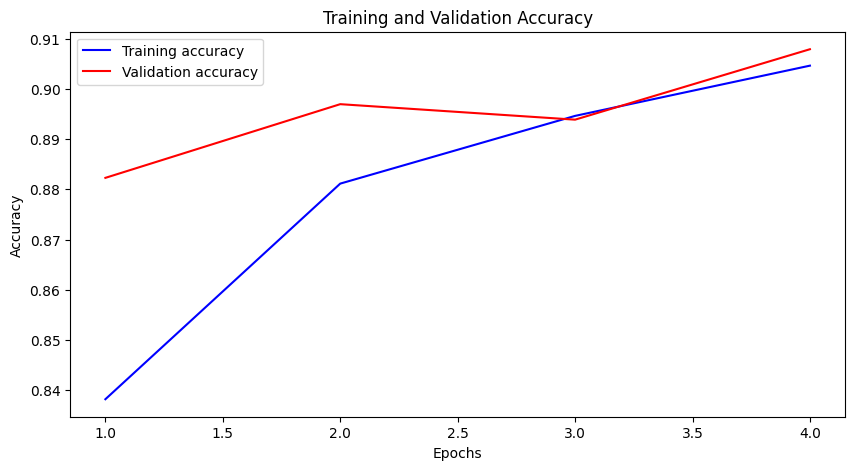

In [86]:
loss_keeper, accuracy_keeper, precision_keeper, recall_keeper = model_4
plot_metrics(loss_keeper, accuracy_keeper)

In [87]:
test_accuracy(model_4_CNN_AvgPool, test_loader)

88.24

#### SGD

In [88]:
model_4 = trainNet(model_4_CNN_AvgPool,0.001,"SGD")


Epoch : 1	Training Loss : 0.20345889240580922	Validation Loss : 0.22762999069450113
Training Accuracy : 0.9272708333333334	Validation Accuracy : 0.9145625
Validation loss decreased from : inf ----> 0.22762999069450113 ----> Saving Model.......

Epoch : 2	Training Loss : 0.1954472522007806	Validation Loss : 0.1984759100538213
Training Accuracy : 0.9291458333333333	Validation Accuracy : 0.9281875
Validation loss decreased from : 0.22762999069450113 ----> 0.1984759100538213 ----> Saving Model.......

Epoch : 3	Training Loss : 0.19203285649535246	Validation Loss : 0.18713369389646686
Training Accuracy : 0.9300416666666667	Validation Accuracy : 0.9333958333333333
Validation loss decreased from : 0.1984759100538213 ----> 0.18713369389646686 ----> Saving Model.......

Epoch : 4	Training Loss : 0.18940420334227384	Validation Loss : 0.18760081624689823
Training Accuracy : 0.9320833333333334	Validation Accuracy : 0.9330416666666667


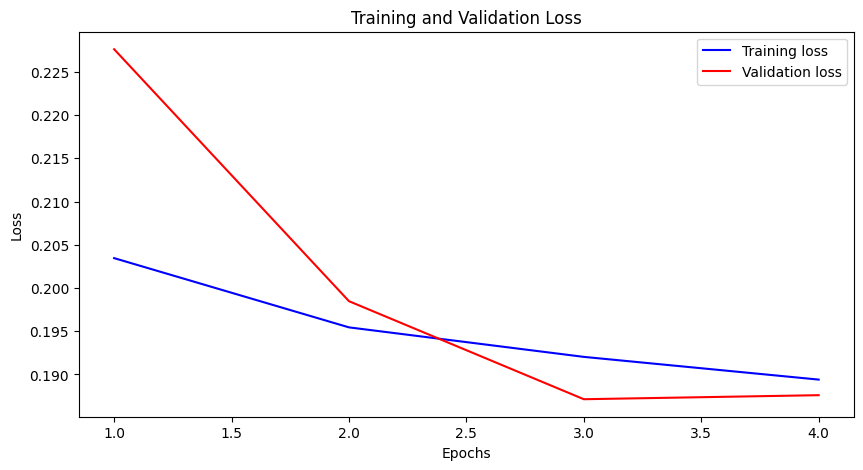

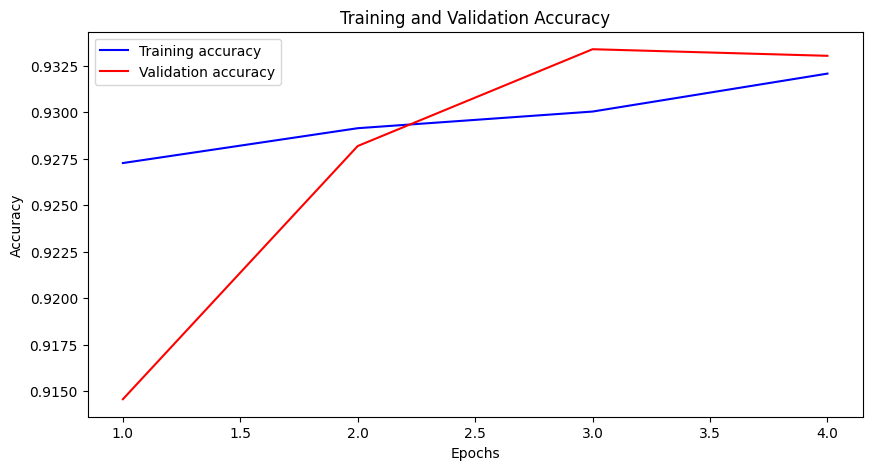

In [89]:
loss_keeper, accuracy_keeper, precision_keeper, recall_keeper = model_4
plot_metrics(loss_keeper, accuracy_keeper)

In [90]:
test_accuracy(model_4_CNN_AvgPool, test_loader)

90.53

#### RMSprop

In [91]:
model_4 = trainNet(model_4_CNN_AvgPool,0.001,"RMSprop")


Epoch : 1	Training Loss : 0.2513529060833389	Validation Loss : 0.19758508137621297
Training Accuracy : 0.9089583333333333	Validation Accuracy : 0.9274166666666667
Validation loss decreased from : inf ----> 0.19758508137621297 ----> Saving Model.......

Epoch : 2	Training Loss : 0.22124787172098878	Validation Loss : 0.1905708215176128
Training Accuracy : 0.9185833333333333	Validation Accuracy : 0.9298125
Validation loss decreased from : 0.19758508137621297 ----> 0.1905708215176128 ----> Saving Model.......

Epoch : 3	Training Loss : 0.2070659568515839	Validation Loss : 0.17504754772725087
Training Accuracy : 0.9230208333333333	Validation Accuracy : 0.9347291666666667
Validation loss decreased from : 0.1905708215176128 ----> 0.17504754772725087 ----> Saving Model.......

Epoch : 4	Training Loss : 0.19575735002969546	Validation Loss : 0.1878634876087987
Training Accuracy : 0.9275625	Validation Accuracy : 0.9332291666666667


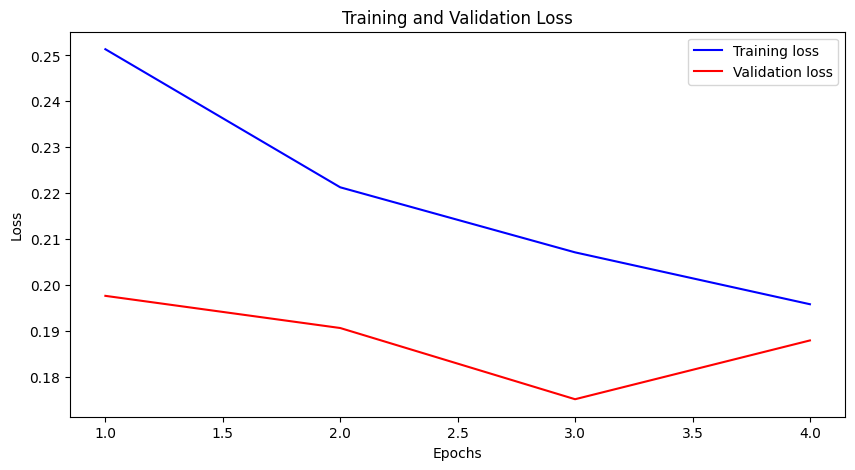

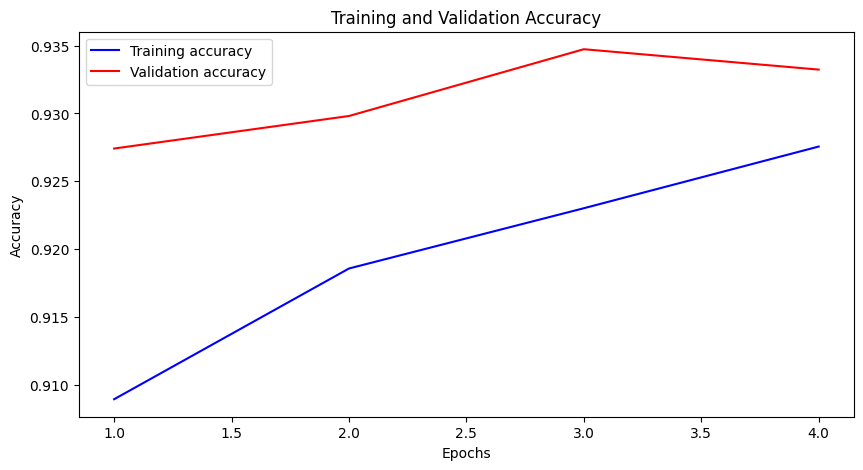

In [92]:
loss_keeper, accuracy_keeper, precision_keeper, recall_keeper = model_4
plot_metrics(loss_keeper, accuracy_keeper)

In [93]:
test_accuracy(model_4_CNN_AvgPool, test_loader)

89.9

### 5th model Net5

#### Adam

In [94]:
model_5 = trainNet(model_5_Net5,0.001,"Adam")


Epoch : 1	Training Loss : 0.5247394389829909	Validation Loss : 0.391514483980524
Training Accuracy : 0.8078333333333333	Validation Accuracy : 0.8574791666666667
Validation loss decreased from : inf ----> 0.391514483980524 ----> Saving Model.......

Epoch : 2	Training Loss : 0.38049671755637976	Validation Loss : 0.33493549245720106
Training Accuracy : 0.8627708333333334	Validation Accuracy : 0.8747708333333334
Validation loss decreased from : 0.391514483980524 ----> 0.33493549245720106 ----> Saving Model.......

Epoch : 3	Training Loss : 0.3366732935366842	Validation Loss : 0.3133301044239973
Training Accuracy : 0.8759375	Validation Accuracy : 0.8853958333333334
Validation loss decreased from : 0.33493549245720106 ----> 0.3133301044239973 ----> Saving Model.......

Epoch : 4	Training Loss : 0.3075081266354149	Validation Loss : 0.2751423600234557
Training Accuracy : 0.8870416666666666	Validation Accuracy : 0.8988541666666666
Validation loss decreased from : 0.3133301044239973 ----> 0.27

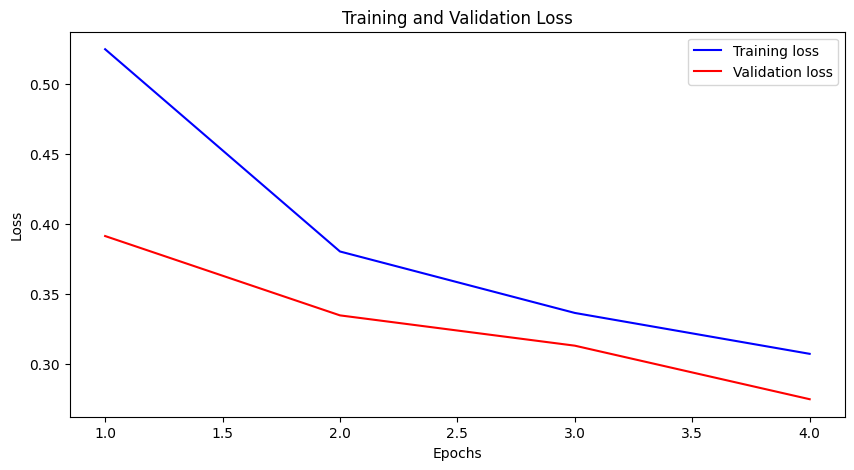

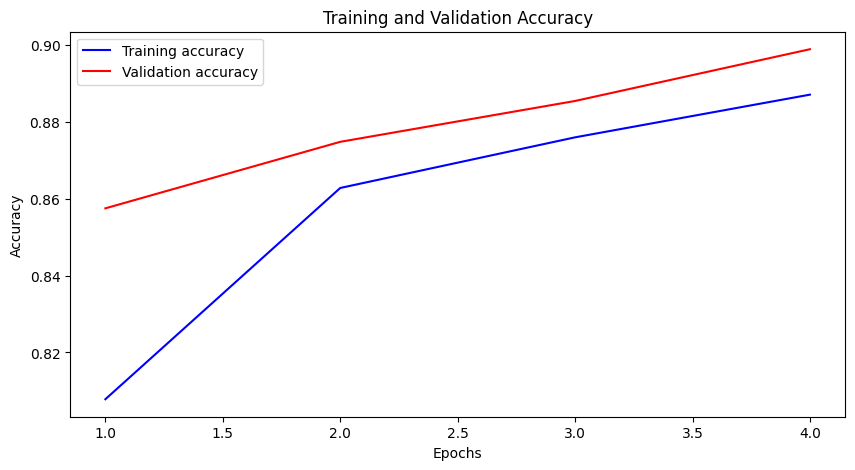

In [95]:
loss_keeper, accuracy_keeper, precision_keeper, recall_keeper = model_5
plot_metrics(loss_keeper, accuracy_keeper)

In [96]:
test_accuracy(model_5_Net5, test_loader)

87.41

#### SGD

In [97]:
model_5 = trainNet(model_5_Net5,0.001,"SGD")


Epoch : 1	Training Loss : 0.2654125654650852	Validation Loss : 0.2603194354940206
Training Accuracy : 0.9036458333333334	Validation Accuracy : 0.905375
Validation loss decreased from : inf ----> 0.2603194354940206 ----> Saving Model.......

Epoch : 2	Training Loss : 0.25831873089075086	Validation Loss : 0.25589488254200354
Training Accuracy : 0.9065416666666667	Validation Accuracy : 0.9073541666666667
Validation loss decreased from : 0.2603194354940206 ----> 0.25589488254200354 ----> Saving Model.......

Epoch : 3	Training Loss : 0.2548077955803213	Validation Loss : 0.2529487219802104
Training Accuracy : 0.9073958333333333	Validation Accuracy : 0.9081875
Validation loss decreased from : 0.25589488254200354 ----> 0.2529487219802104 ----> Saving Model.......

Epoch : 4	Training Loss : 0.25243622076231986	Validation Loss : 0.250893195909836
Training Accuracy : 0.908125	Validation Accuracy : 0.9091458333333333
Validation loss decreased from : 0.2529487219802104 ----> 0.250893195909836 ---

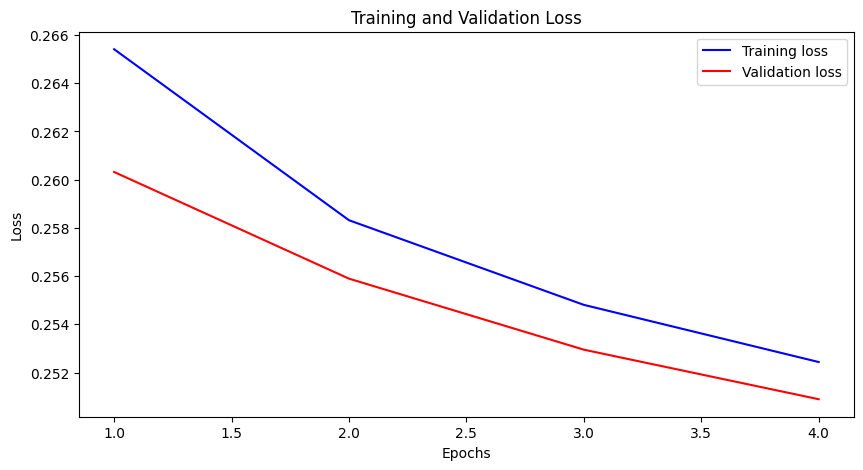

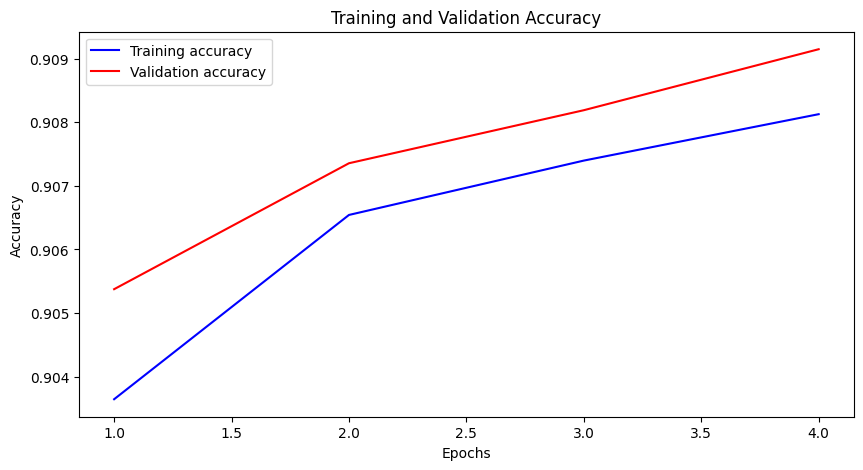

In [98]:
loss_keeper, accuracy_keeper, precision_keeper, recall_keeper = model_5
plot_metrics(loss_keeper, accuracy_keeper)

In [99]:
test_accuracy(model_5_Net5, test_loader)

88.29

#### RMSprop

In [100]:
model_5 = trainNet(model_5_Net5,0.001,"RMSprop")


Epoch : 1	Training Loss : 0.2912348824025442	Validation Loss : 0.27292454490515716
Training Accuracy : 0.8917916666666666	Validation Accuracy : 0.896
Validation loss decreased from : inf ----> 0.27292454490515716 ----> Saving Model.......

Epoch : 2	Training Loss : 0.2688929685484618	Validation Loss : 0.24282471215895687
Training Accuracy : 0.900125	Validation Accuracy : 0.9108333333333334
Validation loss decreased from : 0.27292454490515716 ----> 0.24282471215895687 ----> Saving Model.......

Epoch : 3	Training Loss : 0.2541578021909421	Validation Loss : 0.22647925583296455
Training Accuracy : 0.9054791666666666	Validation Accuracy : 0.9161666666666667
Validation loss decreased from : 0.24282471215895687 ----> 0.22647925583296455 ----> Saving Model.......

Epoch : 4	Training Loss : 0.2370806830500563	Validation Loss : 0.2117168706418791
Training Accuracy : 0.9123333333333333	Validation Accuracy : 0.92175
Validation loss decreased from : 0.22647925583296455 ----> 0.2117168706418791 --

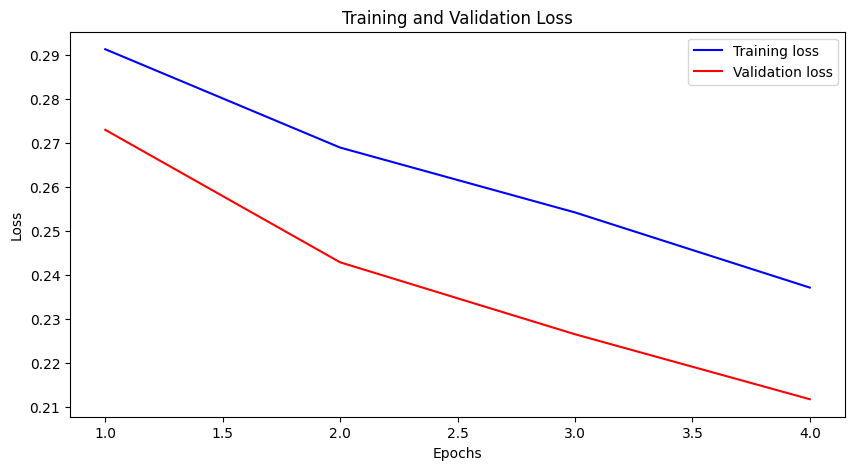

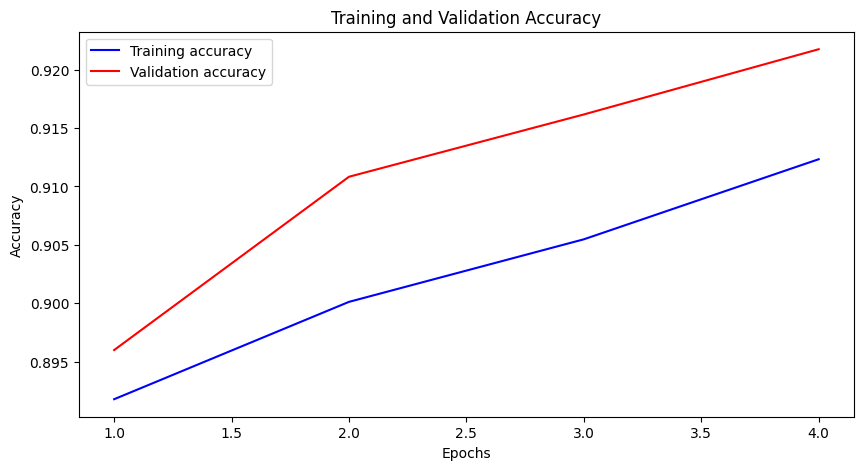

In [101]:
loss_keeper, accuracy_keeper, precision_keeper, recall_keeper = model_5
plot_metrics(loss_keeper, accuracy_keeper)

In [102]:
test_accuracy(model_5_Net5, test_loader)

88.57

### 6th model Net5 + sigmoid

#### Adam

In [103]:
model_6 = trainNet(model_6_Net5_sig_max,0.001,"Adam")


Epoch : 1	Training Loss : 0.9562937378076216	Validation Loss : 0.6110067571389178
Training Accuracy : 0.6374791666666667	Validation Accuracy : 0.7650416666666666
Validation loss decreased from : inf ----> 0.6110067571389178 ----> Saving Model.......

Epoch : 2	Training Loss : 0.5418416109867394	Validation Loss : 0.4822506969717021
Training Accuracy : 0.795375	Validation Accuracy : 0.8188541666666667
Validation loss decreased from : 0.6110067571389178 ----> 0.4822506969717021 ----> Saving Model.......

Epoch : 3	Training Loss : 0.46418771780095996	Validation Loss : 0.4190237815088282
Training Accuracy : 0.8256458333333333	Validation Accuracy : 0.8424375
Validation loss decreased from : 0.4822506969717021 ----> 0.4190237815088282 ----> Saving Model.......

Epoch : 4	Training Loss : 0.419186648253041	Validation Loss : 0.3953314457833767
Training Accuracy : 0.8440833333333333	Validation Accuracy : 0.854375
Validation loss decreased from : 0.4190237815088282 ----> 0.3953314457833767 ----> 

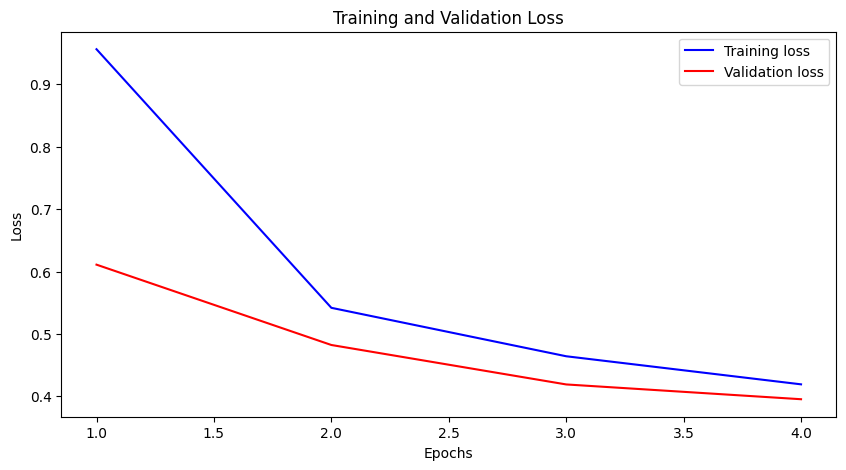

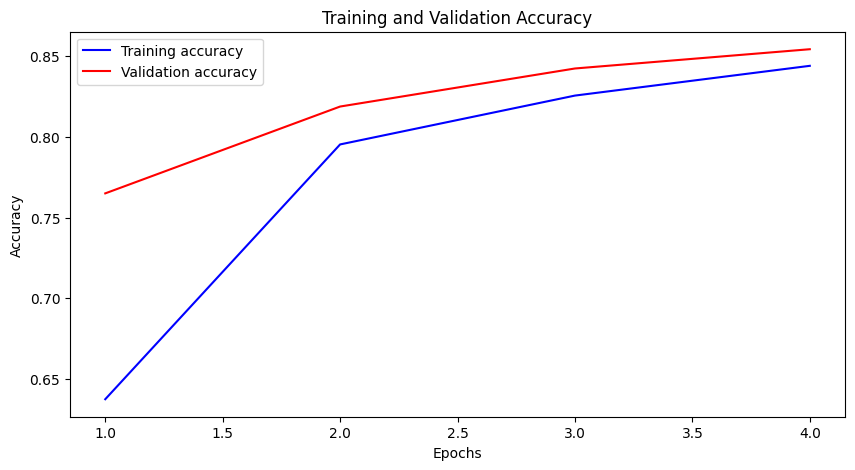

In [104]:
loss_keeper, accuracy_keeper, precision_keeper, recall_keeper = model_6
plot_metrics(loss_keeper, accuracy_keeper)

In [105]:
test_accuracy(model_6_Net5_sig_max, test_loader)

84.3

#### SGD

In [106]:
model_6 = trainNet(model_6_Net5_sig_max,0.001,"SGD")


Epoch : 1	Training Loss : 0.3819649559321503	Validation Loss : 0.3785624447201068
Training Accuracy : 0.8601458333333334	Validation Accuracy : 0.8609166666666667
Validation loss decreased from : inf ----> 0.3785624447201068 ----> Saving Model.......

Epoch : 2	Training Loss : 0.37768231170329575	Validation Loss : 0.3763855000802626
Training Accuracy : 0.8609583333333334	Validation Accuracy : 0.8614583333333333
Validation loss decreased from : 0.3785624447201068 ----> 0.3763855000802626 ----> Saving Model.......

Epoch : 3	Training Loss : 0.3759040776803158	Validation Loss : 0.37521312294527887
Training Accuracy : 0.8613333333333333	Validation Accuracy : 0.862375
Validation loss decreased from : 0.3763855000802626 ----> 0.37521312294527887 ----> Saving Model.......

Epoch : 4	Training Loss : 0.3747074811719358	Validation Loss : 0.37392454530578106
Training Accuracy : 0.8615833333333334	Validation Accuracy : 0.8615416666666667
Validation loss decreased from : 0.37521312294527887 ----> 0

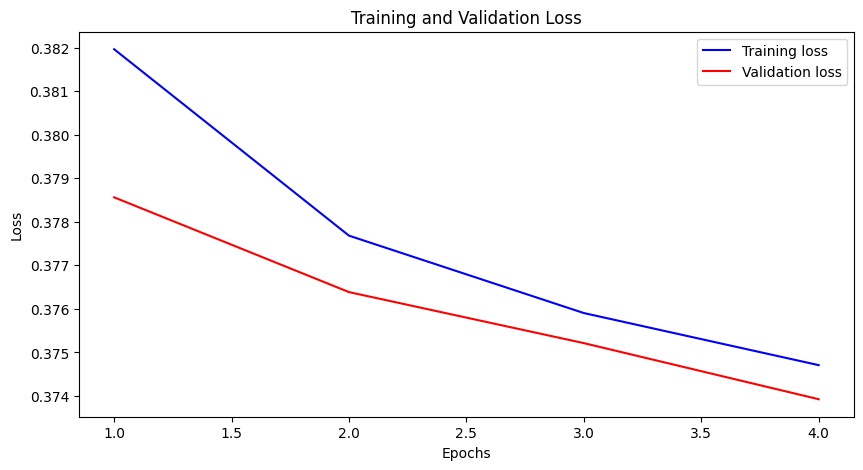

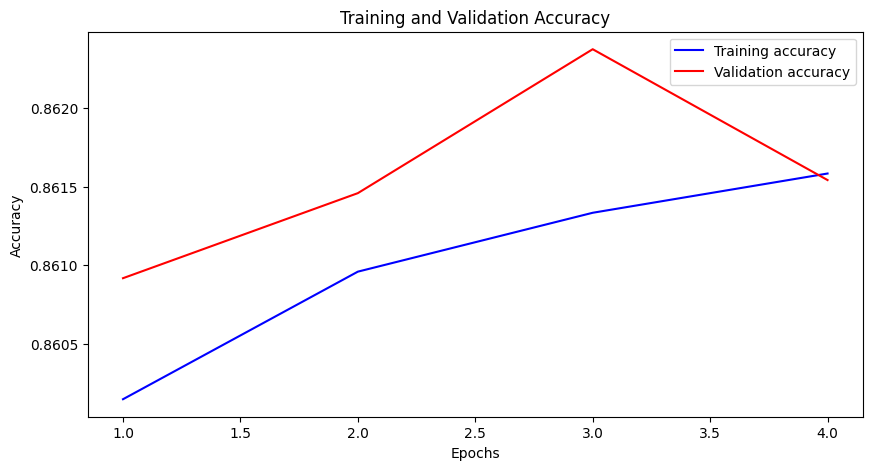

In [107]:
loss_keeper, accuracy_keeper, precision_keeper, recall_keeper = model_6
plot_metrics(loss_keeper, accuracy_keeper)

In [108]:
test_accuracy(model_6_Net5_sig_max, test_loader)

84.97

#### RMSprop

In [109]:
model_6 = trainNet(model_6_Net5_sig_max,0.001,"RMSprop")


Epoch : 1	Training Loss : 0.39469092689454555	Validation Loss : 0.37390222735392553
Training Accuracy : 0.8505208333333333	Validation Accuracy : 0.8595208333333333
Validation loss decreased from : inf ----> 0.37390222735392553 ----> Saving Model.......

Epoch : 2	Training Loss : 0.36996705462380003	Validation Loss : 0.3431985146094424
Training Accuracy : 0.8613958333333334	Validation Accuracy : 0.8717291666666667
Validation loss decreased from : 0.37390222735392553 ----> 0.3431985146094424 ----> Saving Model.......

Epoch : 3	Training Loss : 0.3501333770590524	Validation Loss : 0.34770614543153594
Training Accuracy : 0.8694375	Validation Accuracy : 0.8706458333333333

Epoch : 4	Training Loss : 0.33473108583906047	Validation Loss : 0.32266941173855834
Training Accuracy : 0.8735833333333334	Validation Accuracy : 0.8771875
Validation loss decreased from : 0.3431985146094424 ----> 0.32266941173855834 ----> Saving Model.......


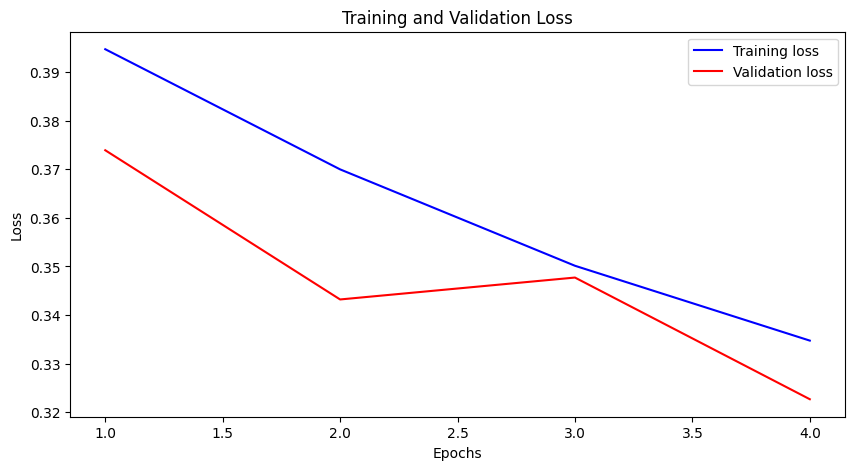

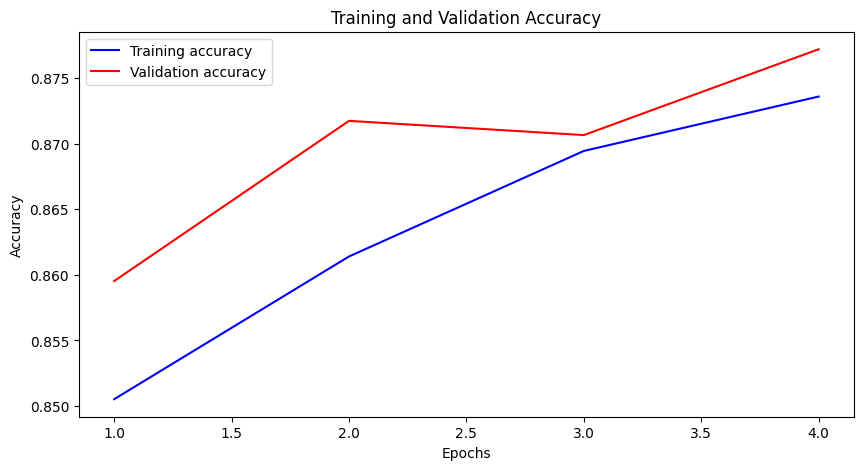

In [110]:
loss_keeper, accuracy_keeper, precision_keeper, recall_keeper = model_6
plot_metrics(loss_keeper, accuracy_keeper)

In [111]:
test_accuracy(model_6_Net5_sig_max, test_loader)

86.29

### 7th model CNN + droopdown

#### Adam

In [132]:
model_7 = trainNet(model_7_convNet_DropModel,0.001,"Adam")


Epoch : 1	Training Loss : 0.4513643825861315	Validation Loss : 0.31981567973503844
Training Accuracy : 0.836125	Validation Accuracy : 0.8842916666666667
Validation loss decreased from : inf ----> 0.31981567973503844 ----> Saving Model.......

Epoch : 2	Training Loss : 0.3388281739549711	Validation Loss : 0.331516444903488
Training Accuracy : 0.8747291666666667	Validation Accuracy : 0.8763125

Epoch : 3	Training Loss : 0.30296581153486235	Validation Loss : 0.27966560365321735
Training Accuracy : 0.8907083333333333	Validation Accuracy : 0.8935833333333333
Validation loss decreased from : 0.31981567973503844 ----> 0.27966560365321735 ----> Saving Model.......

Epoch : 4	Training Loss : 0.27896410984549824	Validation Loss : 0.2523106733772632
Training Accuracy : 0.8962708333333333	Validation Accuracy : 0.9049375
Validation loss decreased from : 0.27966560365321735 ----> 0.2523106733772632 ----> Saving Model.......


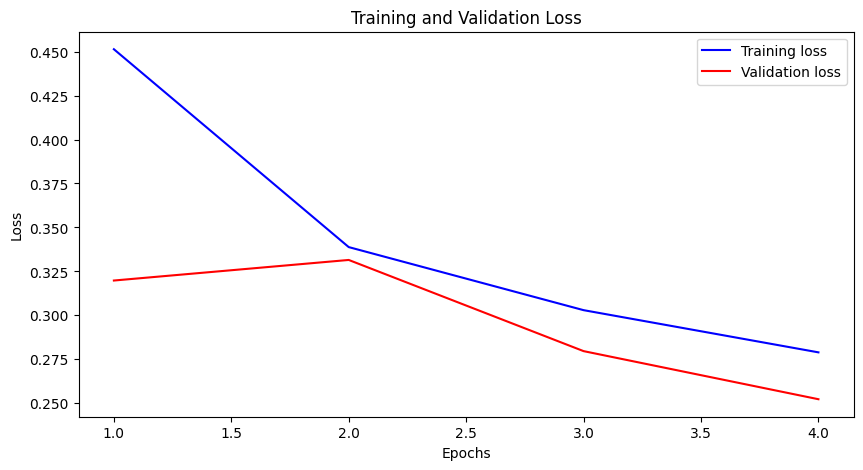

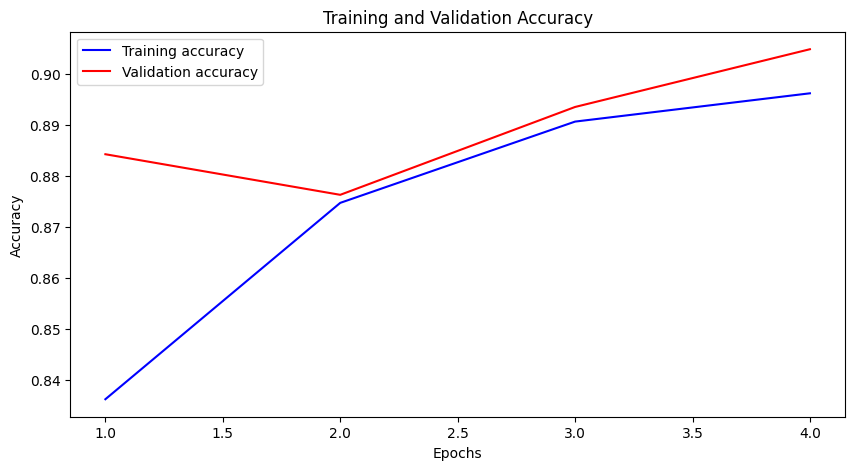

In [133]:
loss_keeper, accuracy_keeper, precision_keeper, recall_keeper = model_7
plot_metrics(loss_keeper, accuracy_keeper)

In [134]:
test_accuracy(model_7_convNet_DropModel, test_loader)

88.66

#### SGD

In [135]:
model_7 = trainNet(model_7_convNet_DropModel,0.001,"SGD")


Epoch : 1	Training Loss : 0.22344582706224173	Validation Loss : 0.2052618042655134
Training Accuracy : 0.9181875	Validation Accuracy : 0.9246666666666666
Validation loss decreased from : inf ----> 0.2052618042655134 ----> Saving Model.......

Epoch : 2	Training Loss : 0.21499144262595413	Validation Loss : 0.20224824006339379
Training Accuracy : 0.9213958333333333	Validation Accuracy : 0.926
Validation loss decreased from : 0.2052618042655134 ----> 0.20224824006339379 ----> Saving Model.......

Epoch : 3	Training Loss : 0.2140313840653592	Validation Loss : 0.200116687315749
Training Accuracy : 0.9212916666666666	Validation Accuracy : 0.9269583333333333
Validation loss decreased from : 0.20224824006339379 ----> 0.200116687315749 ----> Saving Model.......

Epoch : 4	Training Loss : 0.21077291498930814	Validation Loss : 0.1968510572433782
Training Accuracy : 0.9221041666666666	Validation Accuracy : 0.9276458333333333
Validation loss decreased from : 0.200116687315749 ----> 0.1968510572433

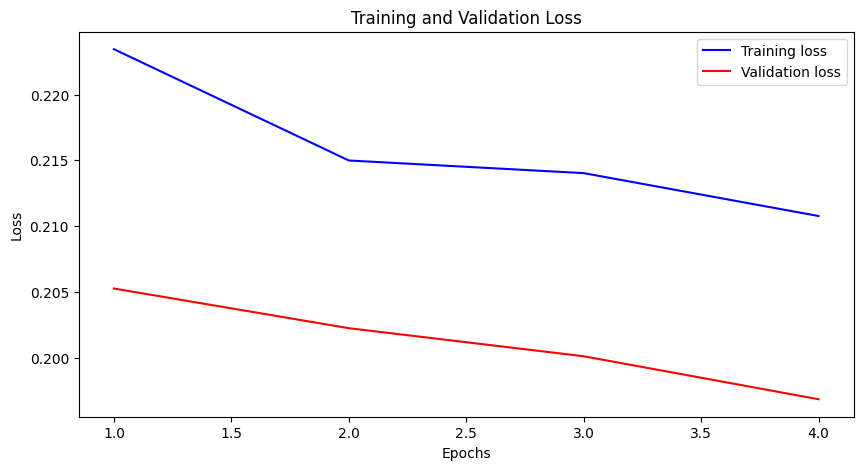

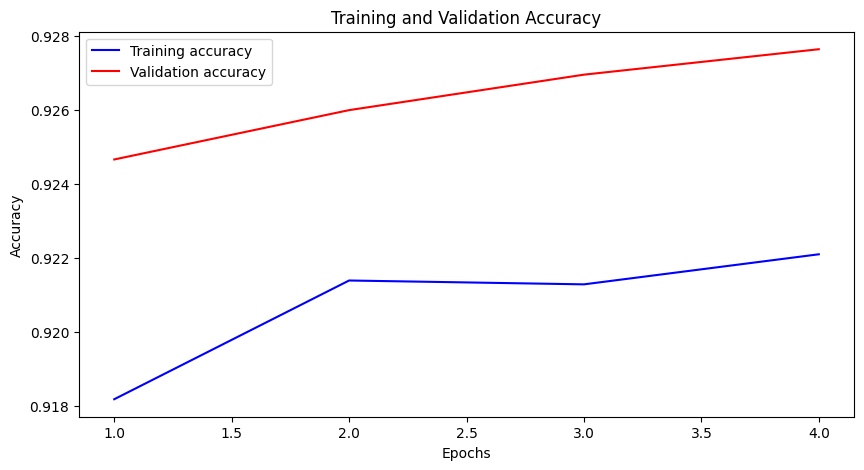

In [136]:
loss_keeper, accuracy_keeper, precision_keeper, recall_keeper = model_7
plot_metrics(loss_keeper, accuracy_keeper)

In [137]:
test_accuracy(model_7_convNet_DropModel, test_loader)

90.53

#### RMSprop

In [138]:
model_7 = trainNet(model_7_convNet_DropModel,0.001,"RMSprop")


Epoch : 1	Training Loss : 0.26942680031837274	Validation Loss : 0.2284770863307252
Training Accuracy : 0.9026875	Validation Accuracy : 0.9134375
Validation loss decreased from : inf ----> 0.2284770863307252 ----> Saving Model.......

Epoch : 2	Training Loss : 0.245474928378826	Validation Loss : 0.21332989755591067
Training Accuracy : 0.909875	Validation Accuracy : 0.9220208333333333
Validation loss decreased from : 0.2284770863307252 ----> 0.21332989755591067 ----> Saving Model.......

Epoch : 3	Training Loss : 0.22981663483932305	Validation Loss : 0.19083656153088668
Training Accuracy : 0.9154375	Validation Accuracy : 0.928
Validation loss decreased from : 0.21332989755591067 ----> 0.19083656153088668 ----> Saving Model.......

Epoch : 4	Training Loss : 0.22050140827253928	Validation Loss : 0.1821309425350046
Training Accuracy : 0.9185833333333333	Validation Accuracy : 0.9328125
Validation loss decreased from : 0.19083656153088668 ----> 0.1821309425350046 ----> Saving Model.......


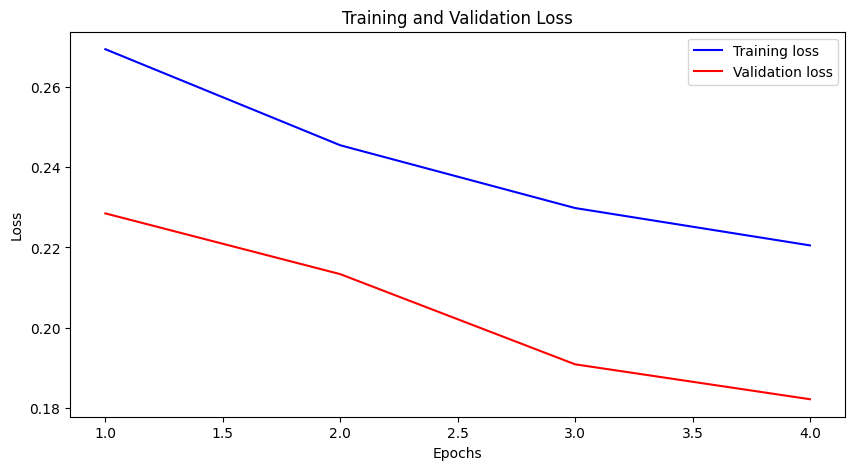

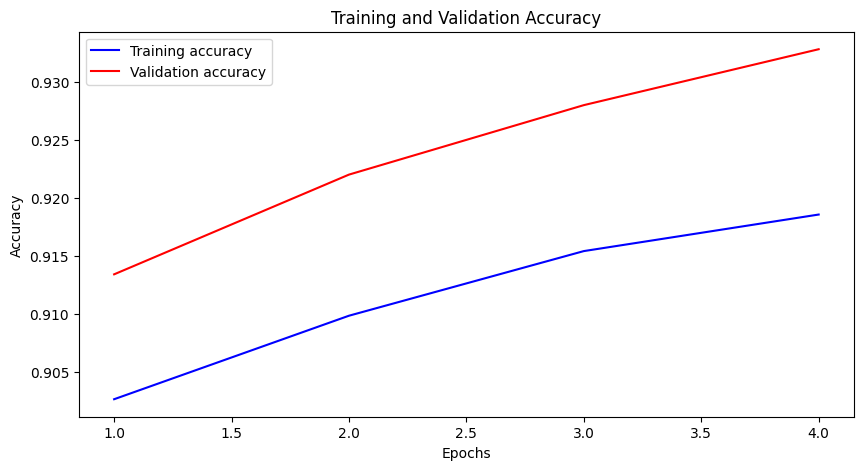

In [139]:
loss_keeper, accuracy_keeper, precision_keeper, recall_keeper = model_7
plot_metrics(loss_keeper, accuracy_keeper)

In [140]:
test_accuracy(model_7_convNet_DropModel, test_loader)

90.25

### Using Augmanted data

In [141]:
model_7 = trainNet(model_7_convNet_DropModel,0.001,"RMSprop",Aug = True)


Epoch : 1	Training Loss : 0.36065909202986707	Validation Loss : 0.22833850351395085
Training Accuracy : 0.8713333333333333	Validation Accuracy : 0.9132083333333333
Validation loss decreased from : inf ----> 0.22833850351395085 ----> Saving Model.......

Epoch : 2	Training Loss : 0.31811279957493144	Validation Loss : 0.20875881412105324
Training Accuracy : 0.8844583333333333	Validation Accuracy : 0.9224375
Validation loss decreased from : 0.22833850351395085 ----> 0.20875881412105324 ----> Saving Model.......

Epoch : 3	Training Loss : 0.30879969618981706	Validation Loss : 0.22956494481361006
Training Accuracy : 0.8868958333333333	Validation Accuracy : 0.9168541666666666

Epoch : 4	Training Loss : 0.30311278310565587	Validation Loss : 0.2025072058563819
Training Accuracy : 0.8887916666666666	Validation Accuracy : 0.9255208333333333
Validation loss decreased from : 0.20875881412105324 ----> 0.2025072058563819 ----> Saving Model.......


In [142]:
test_accuracy(model_7_convNet_DropModel, test_loader)

90.38

In [127]:
model_5 = trainNet(model_5_Net5,0.001,"SGD",Aug = True)


Epoch : 1	Training Loss : 0.8588955466930444	Validation Loss : 0.2485193388160163
Training Accuracy : 0.7905416666666667	Validation Accuracy : 0.9094791666666666
Validation loss decreased from : inf ----> 0.2485193388160163 ----> Saving Model.......

Epoch : 2	Training Loss : 0.5126026065674766	Validation Loss : 0.2383252937012973
Training Accuracy : 0.8308958333333333	Validation Accuracy : 0.9127708333333333
Validation loss decreased from : 0.2485193388160163 ----> 0.2383252937012973 ----> Saving Model.......

Epoch : 3	Training Loss : 0.4505486124334857	Validation Loss : 0.234202816792919
Training Accuracy : 0.8455	Validation Accuracy : 0.9143958333333333
Validation loss decreased from : 0.2383252937012973 ----> 0.234202816792919 ----> Saving Model.......

Epoch : 4	Training Loss : 0.430128488765719	Validation Loss : 0.23092828768926363
Training Accuracy : 0.8508333333333333	Validation Accuracy : 0.9158333333333334
Validation loss decreased from : 0.234202816792919 ----> 0.230928287

In [128]:
test_accuracy(model_5_Net5, test_loader)

88.4